In [1]:
# Navigate to the root of the project and import necessary libraries
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

device = 'cpu'

/tmp/ipykernel_63505/451883383.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


# Extracting the characters

The sole purpose of this notebook is to extract the components from the images, using src.ocr.pipeline.GlobalPipeline. The results of this pipeline can also be shown using the visualization app, **app_extraction.py**.

Run it like this: ```>> streamlit run app_extraction.py```

In [2]:
from IPython.display import display, Markdown
from hydra.utils import instantiate
from src.ocr.pipeline import GlobalPipeline

from omegaconf import OmegaConf
os.environ["HYDRA_FULL_ERROR"] = "1"

cfg = compose(config_name="extraction_pipeline")
pipeline: GlobalPipeline = instantiate(cfg)
# Display the model configuration
display(Markdown(f"```yaml\n{OmegaConf.to_yaml(cfg)}\n```"))

image_folder = Path('data/datasets/book1')
save_folder = Path('tests_2/book1-complete/')
files = next(os.walk(image_folder))[2]


/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/mathis/Bureau/OCRProject/src/ocr/detection/model_wrapper.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, 

```yaml
_target_: src.ocr.pipeline.GlobalPipeline
device: cuda
craftDetectorParams:
  _target_: src.ocr.params.craftParams
  mag_ratio: 5.0
  canvas_size: 1280
  interpolation: bilinear
  chckpt: models/craft/craft_mlt_25k.pth
craftComponentAnalysisParams:
  _target_: src.ocr.params.craftComponentsParams
  text_threshold: 0.6
  connectivity: 8
  min_area: 18
  min_aspect_ratio: 0.2
  max_aspect_ratio: 5.0
  min_dist: 8.0
  characteristic_distance: 5.0
  neighborhood_radius: 50
imageComponentsPipelineParams:
  _target_: src.ocr.params.imageComponentsParams
  threshold: otsu
  min_image_component_aspect_ratio: 20.0
  min_image_component_axis_major_length_criterion: 100.0
  similarity_threshold: -10.0
  similarity_metric: mahalanobis
  min_box_size:
  - 30
  - 30
  max_box_size:
  - 150
  - 150
  max_aspect_ratio: 3
  max_filled_area_portion: 0.9
  min_area: 200
  cc_filtering: true
  cc_distance_threshold: 50
  cc_min_comp_size: 4000

```

In [ ]:
import matplotlib.cm as cm

def to_cm(img, map='viridis'):
    cmap = cm.get_cmap(map) 
    rgb_image = cmap(img)[..., :3]
    return (rgb_image * 255).astype(np.uint8)

def minmaxnorm(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [4]:
from src.ocr.visualization import visualize_extraction_result
from PIL import Image
import torch
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

def process_file(file):
    im_pil = Image.open(image_folder / file)
    results = pipeline.forward(img_pil=im_pil, verbose=False)
    
    # Save components
    (save_folder / 'components').mkdir(parents=True, exist_ok=True)
    (save_folder / 'craft_components').mkdir(parents=True, exist_ok=True)
    
    # Save directly
    results.characters.save(save_folder / 'components' / f'{file}.npz')
    results.craft_components.save(save_folder / 'craft_components' / f'{file}.npz')
    
    # Visualize
    file_stem = Path(file).stem
    visualize_extraction_result(results, prefix=file_stem, 
                            output_dir=save_folder / 'visualizations',
                            pipeline=pipeline)#
    
# Multithreaded
# with ThreadPoolExecutor(max_workers=1) as executor:
#     list(tqdm(executor.map(process_file, files), total=len(files), desc="Processing files", unit="file"))

list(tqdm((process_file(file) for file in files), total=len(files), desc="Processing files", unit="file"))

Processing files:   0%|          | 0/38 [00:05<?, ?file/s]


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import torch
import cv2
from notebook_utils.viz import visualize_pipeline, proper_overlay, draw_ellipses

for i, file in enumerate(files):
    print(f'Processing file N°{i+1}/{len(files)}')
    im_pil = Image.open(image_folder / file)
    results = pipeline.forward(img_pil=im_pil)
    (save_folder / 'components').mkdir(parents=True, exist_ok=True)
    results.filteredCharacters.save(save_folder / 'components' / file)


    tensor = torch.tensor(np.array(results.img_pil)).permute(2,0,1)[None] / 255
    orig_h, orig_w = tensor.shape[2:]
    # fig = proper_overlay(results, pipeline.craftDetector, (orig_h, orig_w))
    # fig.savefig(Path('saved_figures/craftoutputs/') /  f'output-{i}.png')
    Image.fromarray(results.score_text_components.segm_img).save(Path('saved_figures/craft labels/') /  f'output-{i}.png')
    Image.fromarray(results.filtered_text_components.segm_img).save(Path('saved_figures/craft labels filtered/') /  f'output-{i}.png')
    Image.fromarray(results.merged_text_components.segm_img).save(Path('saved_figures/craft labels merged/') /  f'output-{i}.png')
    Image.fromarray(results.image_components.segm_img).save(Path('saved_figures/img_comps/') /  f'output-{i}.png')
    Image.fromarray(results.filtered_image_components.segm_img).save(Path('saved_figures/filtered_img_comps/') /  f'output-{i}.png')
    Image.fromarray(results.character_components.segm_img).save(Path('saved_figures/chars/') /  f'output-{i}.png')
    Image.fromarray(results.filteredCharacters.segm_img).save(Path('saved_figures/chars_filtered/') /  f'output-{i}.png')

    
    # Create all visualizations with one function call
    # file_stem = Path(file).stem
    # saved_paths = visualize_pipeline(
    #     results, 
    #     save_dir='saved_figures/pipeline_viz',
    #     filename=file_stem,
    #     save_summary=True,
    #     save_deltas=True,
    #     save_stages=False  # Set True if you want detailed stage views
    # )
    
    # print(f"  Saved {len(saved_paths)} visualizations for {file_stem}")


    # # Create ellipse visualization
    # arr = np.array(results.img_pil).copy()  # Use original image
    # comps = results.score_text_components  # CRAFT space (score resolution)
    
    
    # # Save ellipse visualization
    # (Path('saved_figures/ellipses/')).mkdir(parents=True, exist_ok=True)
    # Image.fromarray(arr).save(Path('saved_figures/ellipses/') / f'output-{i}.png')

    # patches, img_patches = extract_patches(results.filteredCharacters, image=np.array(results.img_pil), border=5)

    # for i, patch in enumerate(patches):
    #     folder = Path(save_folder / 'patches_bin' / file)
    #     filepath = f'patch-{i}-bin-file-{file}.jpg'
    #     Image.fromarray((patch*255).astype(np.uint8)).save(folder / filepath, quality=100)

    # for i, patch in enumerate(img_patches):
    #     folder = Path(f'data/extracted/patches_img/book1/')
    #     filepath = f'patch-{i}-bin-file-{file}.jpg'
    #     Image.fromarray(patch).save(folder / filepath, quality=100)

# database.save('data/datasets/databases/book1-complete')

Processing file N°1/38
Image dimensions: 4799 x 3510 x 3
Running CRAFT detection...
CRAFT detection completed
Detecting connected components from CRAFT score...
Found 532 initial text components
Filtering components by area and aspect ratio...
After filtering: 490 components remaining
Merging nearby components...
After merging: 490 final text components
Processing image components and binarization...
Image binarization completed
Found 2087 image components
After image filtering: 2067 components
Final character segmentation: 485 components
Pipeline completed successfully!
Processing file N°2/38
Image dimensions: 4799 x 3510 x 3
Running CRAFT detection...
CRAFT detection completed
Detecting connected components from CRAFT score...
Found 391 initial text components
Filtering components by area and aspect ratio...
After filtering: 368 components remaining
Merging nearby components...
After merging: 368 final text components
Processing image components and binarization...
Image binarization

In [ ]:
preprocessed = pipeline.craftDetector.unnormalize(results.preprocessed).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)[0]
# score_img = to_cm(minmaxnorm(results.score_text.cpu().numpy()[0]))
score_img = to_cm((results.score_text.cpu().numpy()[0] > 0.6).astype(np.float32))
alpha = 0.6
arr = (preprocessed[::2,::2] * alpha + score_img * (1-alpha)).astype(np.uint8)

arr = draw_ellipses(pipeline, results, results.score_text_components, arr, score=False, color_line=(255,0,0), color_point=(255, 0, 0))
arr = draw_ellipses(pipeline, results, results.filtered_text_components, arr, score=False, color_line=(0,255,0), color_point=None)

Image.fromarray(arr)


NameError: name 'results' is not defined

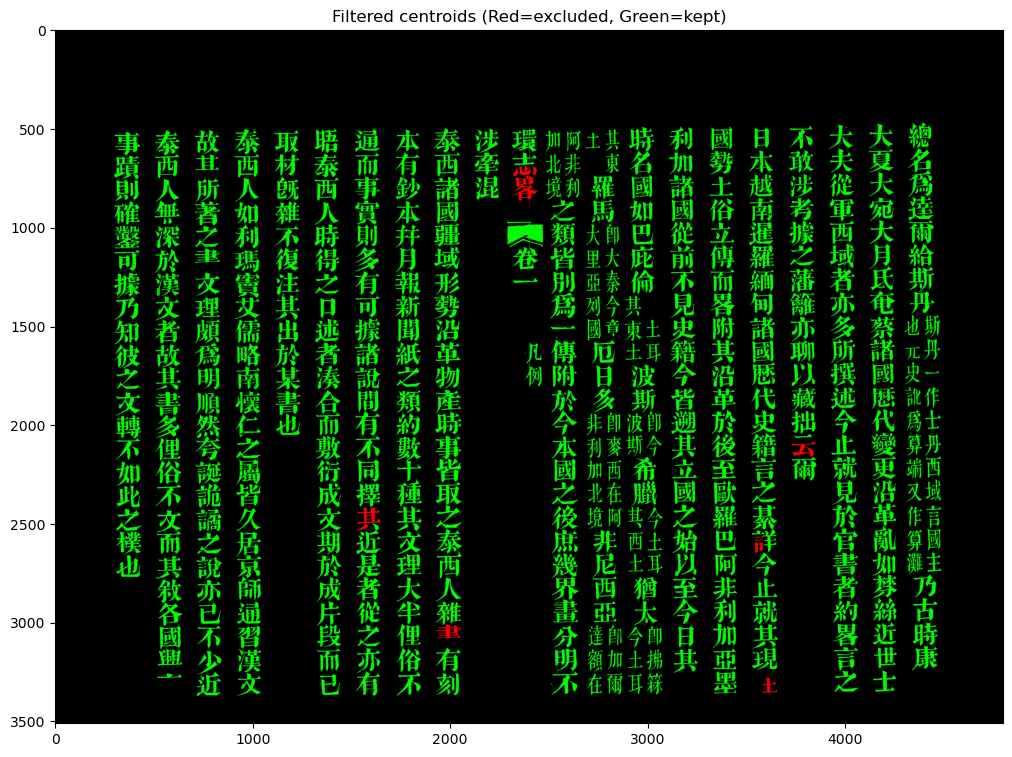

In [ ]:
# binary_img, img_components, filtered_img_components, \
#     associated_components, filtered_characters = pipeline.forward(im_pil, craftComponents)

filtered_characters = results.character_components
img_components = results.image_components

# Now filter centroids that are too close to large image components:
final_characters = pipeline.imageComponentsPipeline.filter_centroids_by_contour_proximity(
    centroids_components=filtered_characters,  # Characters to filter
    reference_components=img_components,       # Large components to check against
)

# Visualize results
import matplotlib.pyplot as plt

unique_labels = np.unique(filtered_characters.labels)
to_keep_labels = set(np.unique(final_characters.labels))
to_exclude_labels = set(unique_labels) - to_keep_labels

m_exclude = np.isin(filtered_characters.labels, list(to_exclude_labels))
m_keep = np.logical_and(~m_exclude, filtered_characters.labels != 0)

viz = np.zeros((*filtered_characters.labels.shape, 3), dtype=np.uint8)
viz[m_exclude] = [255, 0, 0]   # Red: excluded
viz[m_keep] = [0, 255, 0]      # Green: kept

plt.figure(figsize=(16, 9))
plt.imshow(viz)
# plt.imshow(img_components.segm_img, alpha=0.4)
plt.title(f'Filtered centroids (Red=excluded, Green=kept)')
plt.show()


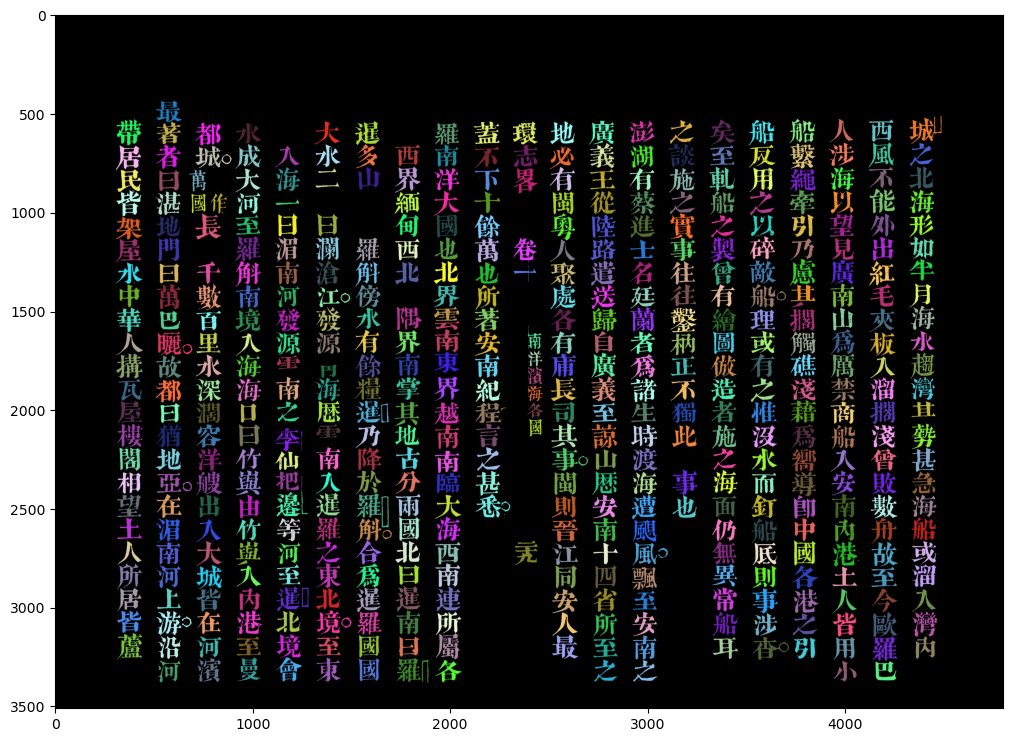

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(results.filteredCharacters.segm_img)

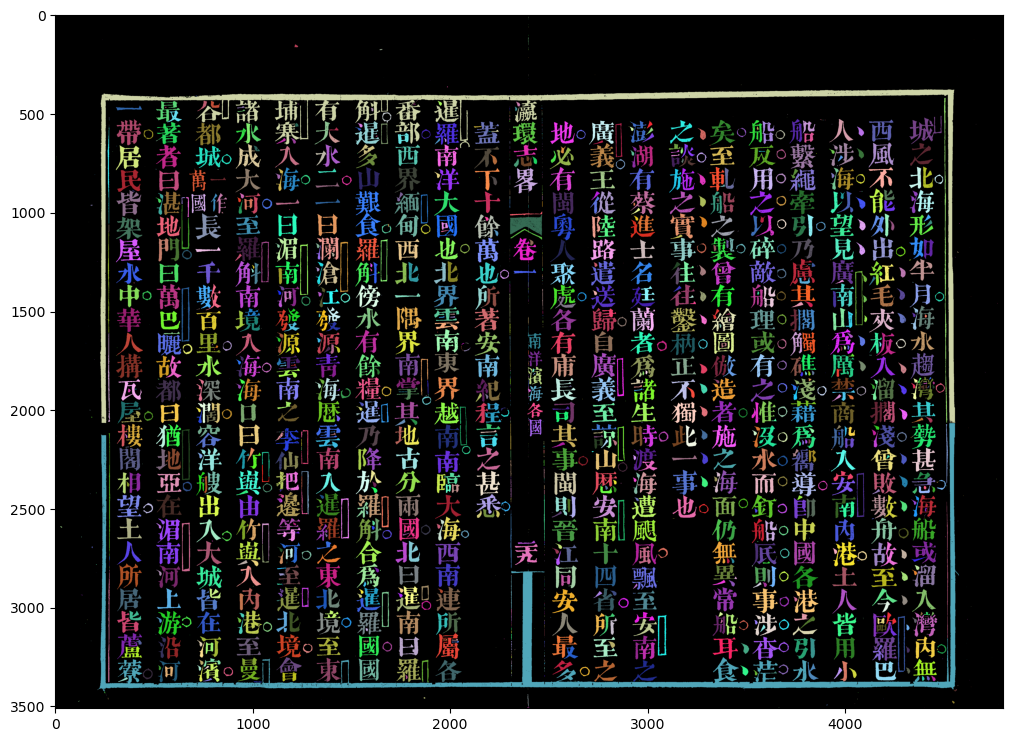

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(results.image_components.segm_img)

Original: (3510, 4799)
Scaled: (936, 1280)
Padded to: (960, 1280)
Score shape (1/2 res): (480, 640)


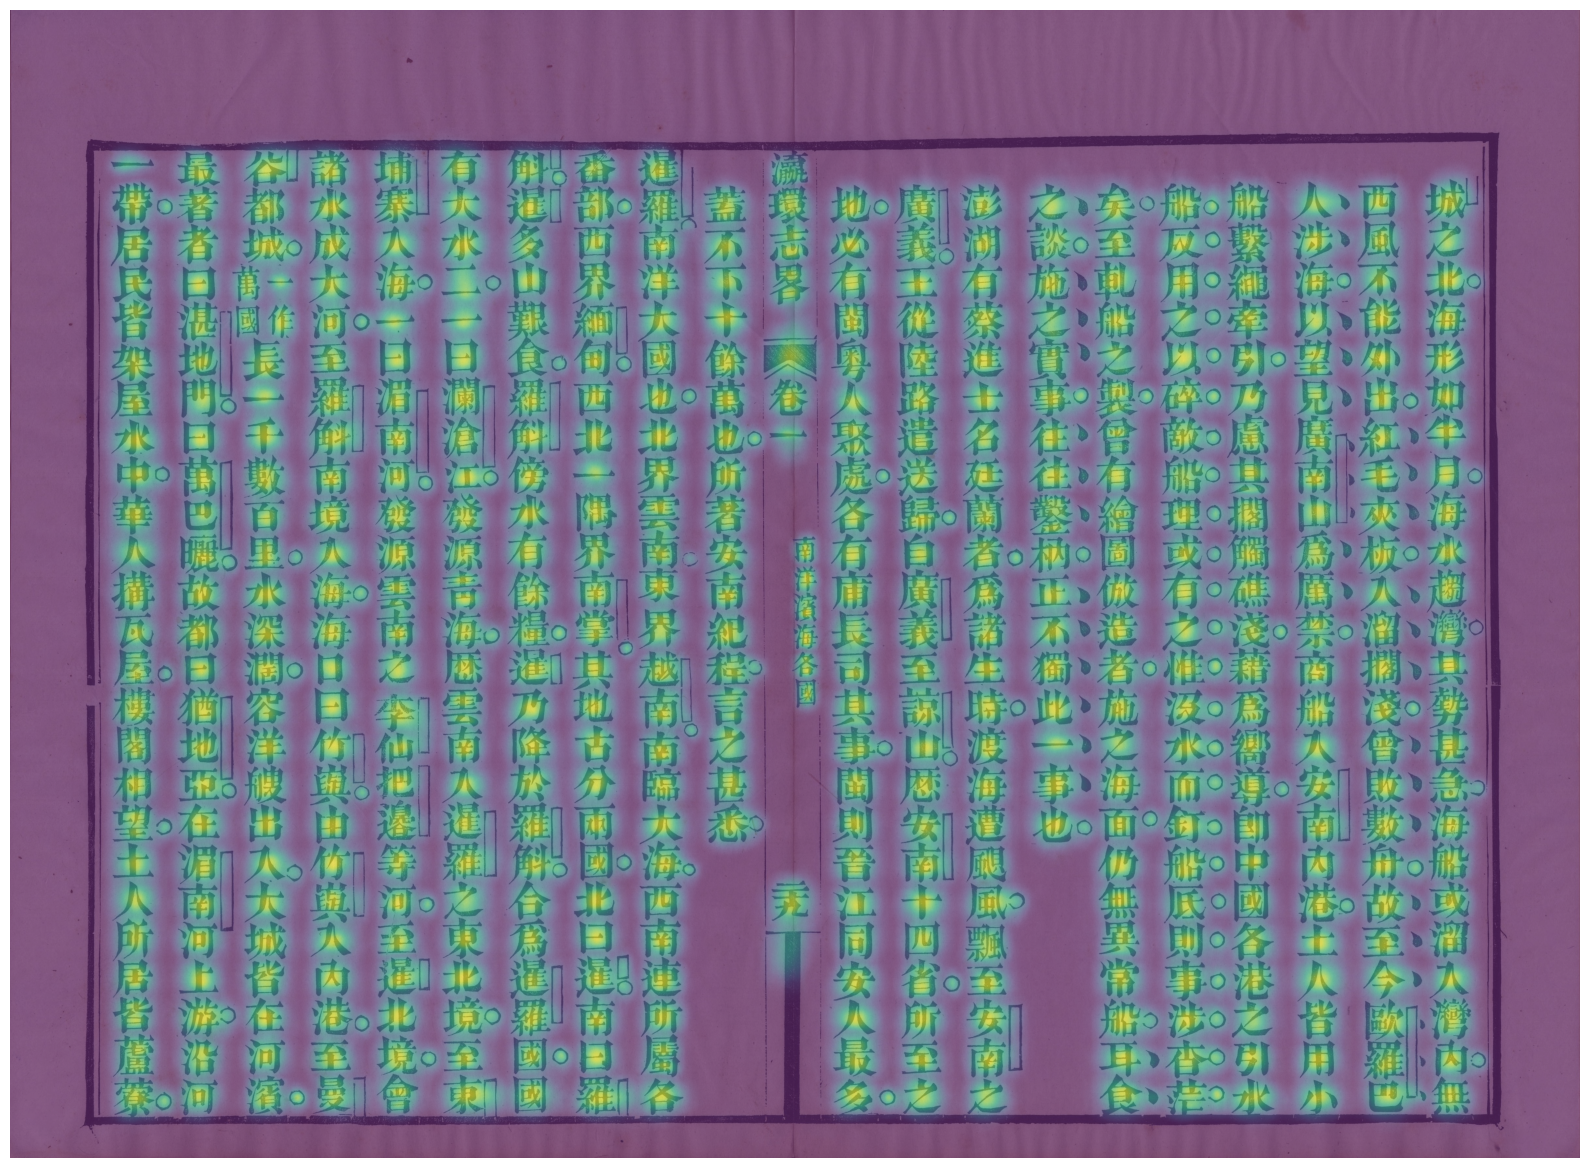

In [ ]:
tensor = torch.tensor(np.array(results.img_pil)).permute(2,0,1)[None] / 255
orig_h, orig_w = tensor.shape[2:]
fig = proper_overlay(results, pipeline.craftDetector, (orig_h, orig_w))

In [ ]:
from src.ocr.patch_extraction import extract_patches

patches, img_patches = extract_patches(results.filteredCharacters, image=np.array(results.img_pil), border=5)

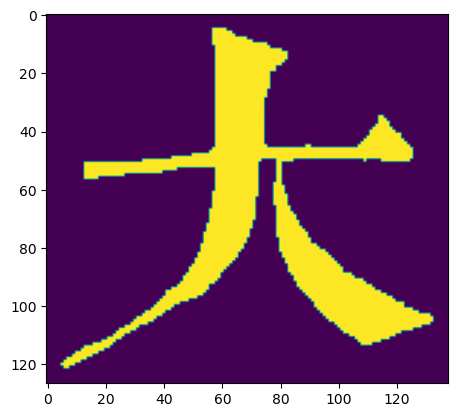

In [ ]:
p = patches[6]

k = np.ones((5,5))
import cv2
p = cv2.morphologyEx(p, cv2.MORPH_CLOSE, k)
plt.imshow(p)
Image.fromarray((1-p).astype(np.uint8)*255).save('closed.jpg', quality=100)